In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.sparse import coo_matrix, triu

def to_matrix(data, chrom1, chrom2, 
              resolution, assembly="hg19",
              start1=None, end1=None, 
              start2=None, end2=None):
    
    if all([x is not None for x in [start1, end1, start2, end2]]):
        start_bin1 = start1//resolution
        end_bin1 = end1//resolution
        start_bin2 = start2//resolution
        end_bin2 = end2//resolution
    else:
        chromsize = load_chromsizes(assembly)
        chromsize1 = chromsize[chrom1]
        chromsize2 = chromsize[chrom2]
        start_bin1 = 0
        end_bin1 = chromsize1//resolution
        start_bin2 = 0
        end_bin2 = chromsize2//resolution
    
    n_bins_1 = end_bin1 - start_bin1 + 1#int(chromsize1 / resolution) + 1
    n_bins_2 = end_bin2 - start_bin2 + 1#int(chromsize2 / resolution) + 1
    
    bin1s = data.bin1//resolution - start_bin1#(data.bin1 / resolution).astype(int).values
    bin2s = data.bin2//resolution - start_bin2#(data.bin2 / resolution).astype(int).values
    values = data.value.values
    m = coo_matrix( (values, (bin1s, bin2s)), shape=(n_bins_1, n_bins_2) )
    if chrom1 == chrom2:
        m = triu(m, k=1).T + m
    return m



def load_tad_list(tad_file, **args):
    tad_dt = pd.read_csv(tad_file, **args)
    if tad_dt.shape[1] == 3:
        #return([np.array(tad_dt.iloc[:,1]), np.array(tad_dt.iloc[:,2])])
        return([list(tad_dt.iloc[:,1]), list(tad_dt.iloc[:,2])])
    else:
        #return([np.array(tad_dt.iloc[:,0]), np.array(tad_dt.iloc[:,1])])
        return([list(tad_dt.iloc[:,0]), list(tad_dt.iloc[:,1])])
    return tad_dt



In [3]:


path = "/media/electron//mnt/ptemp/luca/hic_enhance/data/hic/Rao2014-GM12878-full/Rao2014_observed_NONE_1_1_50000.txt"
#path = "/media/electron//mnt/etemp/marie/FIGURES_V2_YUANLONG/foo_hic.txt"
output_path = "./somewhere.pdf"
chrom = 'chr1'

map_start=0
map_end=20000000


resolution = 50000
shrink=1


In [4]:
data = pd.read_csv(path, sep="\t", header=None, names=['bin1', 'bin2', 'value'])
data_s = data

In [6]:
data = data[(data.bin1>=map_start) & (data.bin2<=map_end)]
m = to_matrix(data, chrom, chrom, resolution, start1=map_start, end1=map_end, start2=map_start, end2=map_end)


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [7]:
tad_file2 = "tad_list_2cols.txt"
tad_toplot = load_tad_list(tad_file2, sep="\t", header=None)


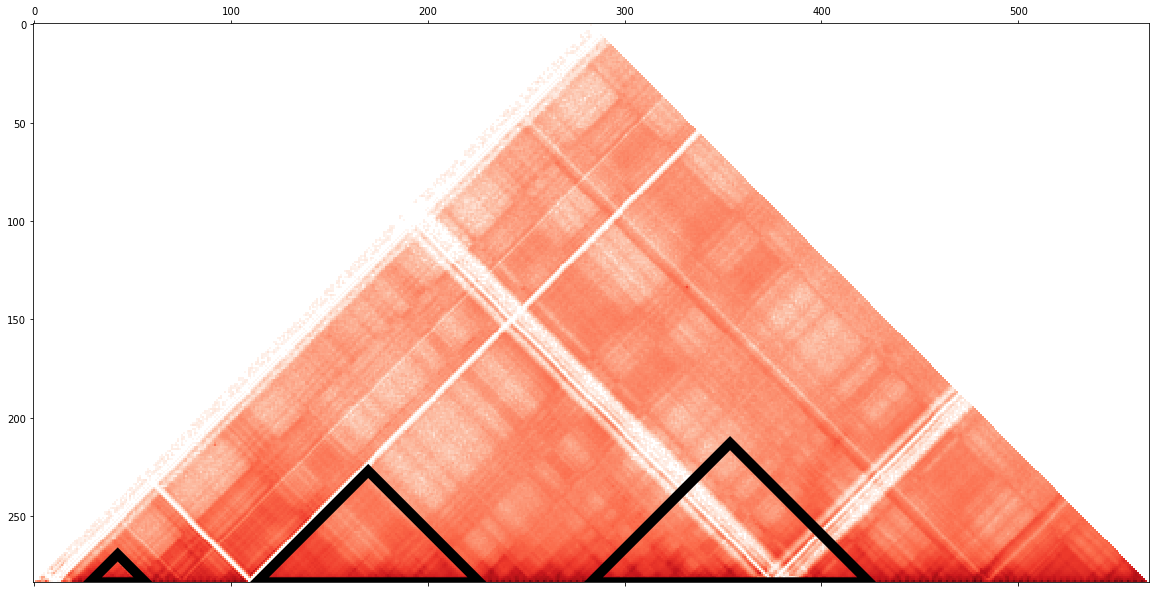

In [9]:
diagonal_height = np.sqrt(m.shape[0]**2 / 2)


my_map = plt.get_cmap("Reds")
my_map.set_under('white')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
X = np.log10(np.triu(m.todense()*shrink) + 1)
ax.matshow( rotate(X, 45), cmap=my_map, vmin=0.01 )

#ax.add_patch(p1)

plt.ylim(diagonal_height)
#plt.xticks([])
#plt.yticks([])
plt.axis('on')


for tad_start, tad_end in zip(tad_toplot[0], tad_toplot[1]):

    tad_start_bin = (tad_start - map_start)//resolution  # tad_pos_1 -> tad_bin_1
    tad_end_bin = (tad_end - map_start)//resolution


    conv_start = np.sqrt(2) * tad_start_bin  # distance to bin start: on the side of the square, it is the # of bins but in triangle plot, it is the diagonal
    conv_end = np.sqrt(2) * tad_end_bin


    tad_triangle = np.array([
        [conv_start,diagonal_height],
        [0.5*(conv_start+conv_end), diagonal_height-(conv_end-conv_start)*0.5],
        [conv_end, diagonal_height]
    ])



    tadTri = plt.Polygon(tad_triangle, facecolor='none', edgecolor='black', linewidth=10)
    ax.add_patch(tadTri)

    

    

